In [6]:
# Ignore  the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# data visualisation and manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
 
#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

#model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

#preprocess.
from keras.preprocessing.image import ImageDataGenerator

#dl libraraies
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from tensorflow.keras.utils import to_categorical

# specifically for cnn
from keras.layers import Dropout, Flatten,Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
 
import tensorflow as tf
import random as rn

# specifically for manipulating zipped images and getting numpy arrays of pixel values of images.
import cv2                  
import numpy as np  
from tqdm import tqdm
import os                   
from random import shuffle  
from zipfile import ZipFile
from PIL import Image


In [12]:
X=[] #list of images
Z=[] #list of labels
IMG_SIZE=150
CARS_DIR='../../datasets/level_1/cars'
HUMAN_DIR='../../datasets/level_1/human'

In [13]:
def assign_label(img,class_type):
    return class_type

In [14]:
def make_train_data(class_type,DIR):
    for img in tqdm(os.listdir(DIR)):
        label=assign_label(img,class_type)
        path = os.path.join(DIR,img)
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        
        X.append(np.array(img))
        Z.append(str(label))

In [15]:
make_train_data('cars' ,CARS_DIR)
print(len(X))

100%|█████████████████████████████████████████████████| 420/420 [00:00<00:00, 2684.64it/s]

420


In [17]:
make_train_data('human', HUMAN_DIR)
print(len(X))

100%|█████████████████████████████████████████████████| 202/202 [00:00<00:00, 1032.43it/s]

824


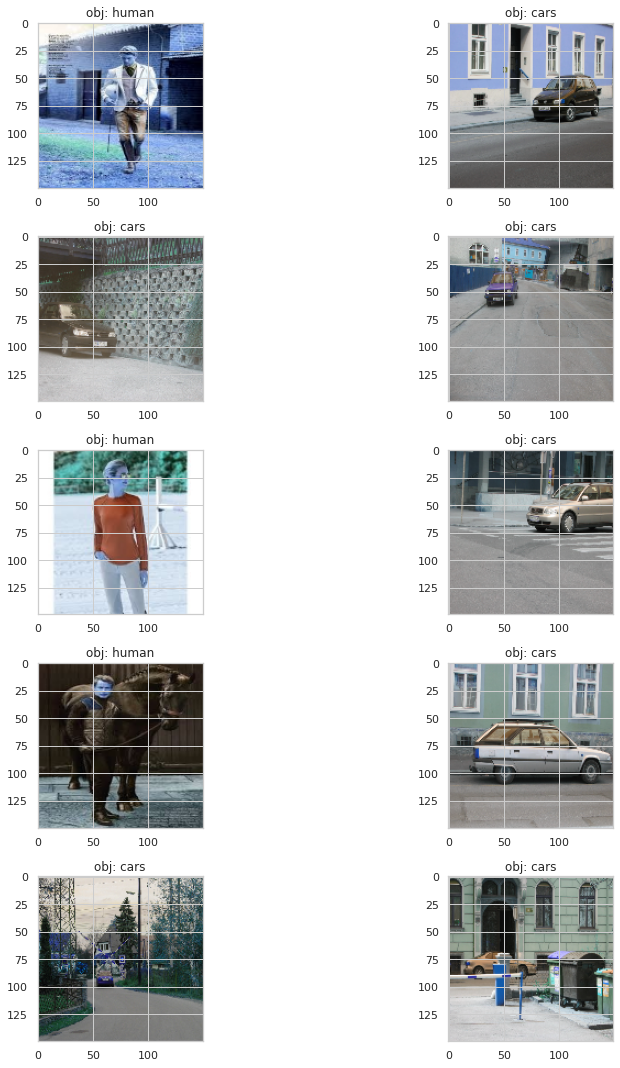

In [18]:
fig, ax = plt.subplots(5, 2)
fig.set_size_inches(15, 15)
for i in range(5):
    for j in range(2):
        l = rn.randint(0, len(Z))
        ax[i, j].imshow(X[l])
        ax[i, j].set_title('obj: '+ Z[l])
        
plt.tight_layout()

In [19]:
le = LabelEncoder()
Y = le.fit_transform(Z)
Y = to_categorical(Y, 2)
X = np.array(X)
X = X/255


In [20]:
x_train, x_test, y_train, y_test = train_test_split(X, 
                                                    Y,
                                                    test_size=0.25,
                                                    random_state=42
                                                   )

In [24]:
np.random.seed(42)
rn.seed(42)
tf.random.set_seed(42)

In [32]:
# # modelling starts using a CNN.

model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = (5,5),
                 padding = 'Same',activation ='relu',
                 input_shape = (150,150,3)))

model.add(MaxPooling2D(pool_size=(2,2)))


model.add(Conv2D(filters = 64, kernel_size = (3,3),
                 padding = 'Same',activation ='relu'))

model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
 

model.add(Conv2D(filters =96, kernel_size = (3,3),
                 padding = 'Same',activation ='relu'))

model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))


model.add(Conv2D(filters = 96, kernel_size = (3,3),
                 padding = 'Same',activation ='relu'))

model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(2, activation = "softmax"))

In [33]:
batch_size = 128
epochs = 50

from keras.callbacks import ReduceLROnPlateau
red_lr= ReduceLROnPlateau(monitor= 'val_acc', patience= 3,
                            verbose= 1, factor= 0.1)

In [34]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

In [35]:
model.compile(optimizer= Adam(lr=0.001),
              loss= 'categorical_crossentropy',
              metrics= ['accuracy']
                 )

In [36]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 150, 150, 32)      2432      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 37, 37, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 37, 37, 96)        55392     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 18, 18, 96)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 18, 18, 96)       

In [37]:

History = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs,
                              validation_data = (x_test,y_test),
                              verbose = 1,
                              steps_per_epoch=x_train.shape[0] // batch_size)

# model.fit(x_train,y_train,epochs=epochs,batch_size=batch_size,validation_data = (x_test,y_test))

Epoch 1/50
4/4 [==============================] - 11s 3s/step - loss: 0.8558 - accuracy: 0.5000 - val_loss: 0.6840 - val_accuracy: 0.4854
Epoch 2/50
4/4 [==============================] - 11s 3s/step - loss: 0.6641 - accuracy: 0.5117 - val_loss: 0.6064 - val_accuracy: 0.5728
Epoch 3/50
4/4 [==============================] - 10s 3s/step - loss: 0.5709 - accuracy: 0.6776 - val_loss: 0.4311 - val_accuracy: 0.8883
Epoch 4/50
4/4 [==============================] - 11s 3s/step - loss: 0.4691 - accuracy: 0.8184 - val_loss: 0.2965 - val_accuracy: 0.8883
Epoch 5/50
4/4 [==============================] - 11s 3s/step - loss: 0.3324 - accuracy: 0.8516 - val_loss: 0.2725 - val_accuracy: 0.8981
Epoch 6/50
4/4 [==============================] - 11s 3s/step - loss: 0.3217 - accuracy: 0.8652 - val_loss: 0.3070 - val_accuracy: 0.8786
Epoch 7/50
4/4 [==============================] - 11s 3s/step - loss: 0.3493 - accuracy: 0.8592 - val_loss: 0.3110 - val_accuracy: 0.8495
Epoch 8/50
4/4 [==================

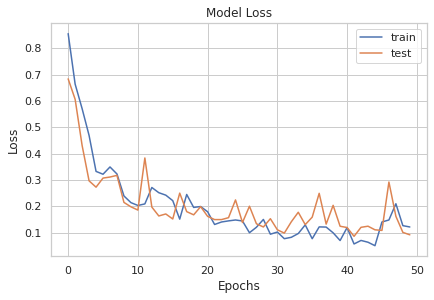

In [38]:
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

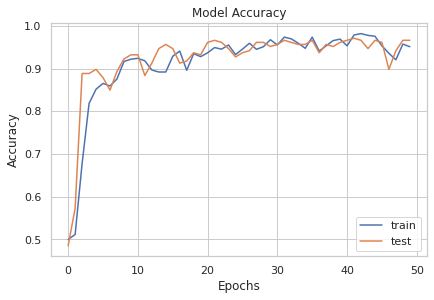

In [41]:
plt.plot(History.history['accuracy'])
plt.plot(History.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

In [42]:
# getting predictions on val set.
pred=model.predict(x_test)
pred_digits=np.argmax(pred,axis=1)

In [51]:
# now storing some properly as well as misclassified indexes'.
i=0
prop_class=[]
mis_class=[]

for i in range(len(y_test)):
    if(np.argmax(y_test[i])==pred_digits[i]):
        prop_class.append(i)
    if(len(prop_class)==8):
        break

i=0
for i in range(len(y_test)):
    if(not np.argmax(y_test[i])==pred_digits[i]):
        mis_class.append(i)
    if(len(mis_class)==8):
        break

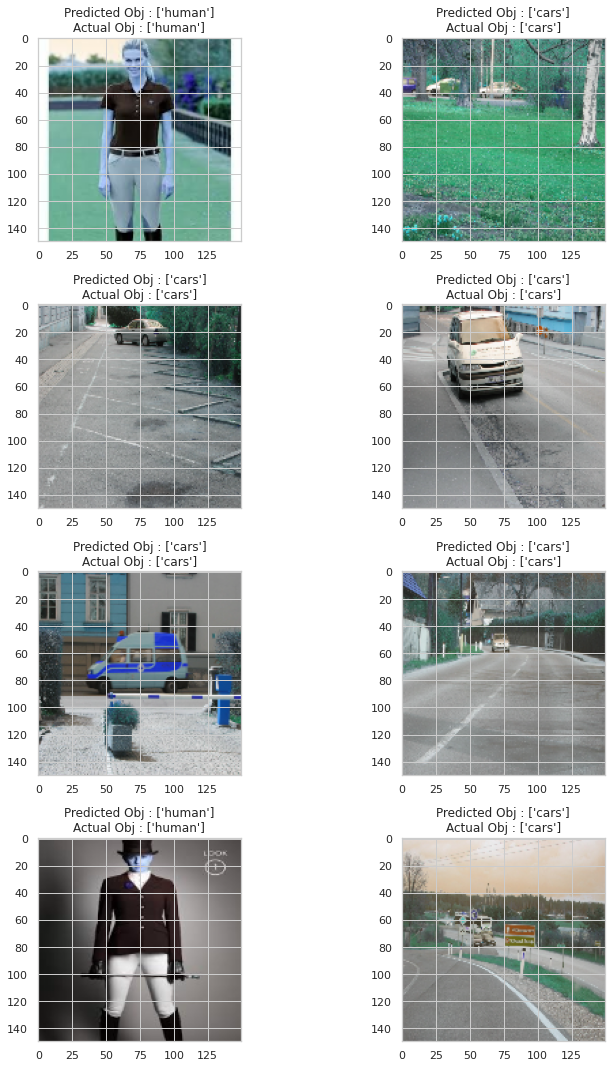

In [52]:
count=0
fig,ax=plt.subplots(4,2)
fig.set_size_inches(15,15)
for i in range (4):
    for j in range (2):
        ax[i,j].imshow(x_test[prop_class[count]])
        ax[i,j].set_title("Predicted Obj : "+
        str(le.inverse_transform([pred_digits[prop_class[count]]]))+
        "\n"+"Actual Obj : "+
        str(le.inverse_transform([np.argmax([y_test[prop_class[count]]])])))
        plt.tight_layout()
        count+=1

IndexError: list index out of range

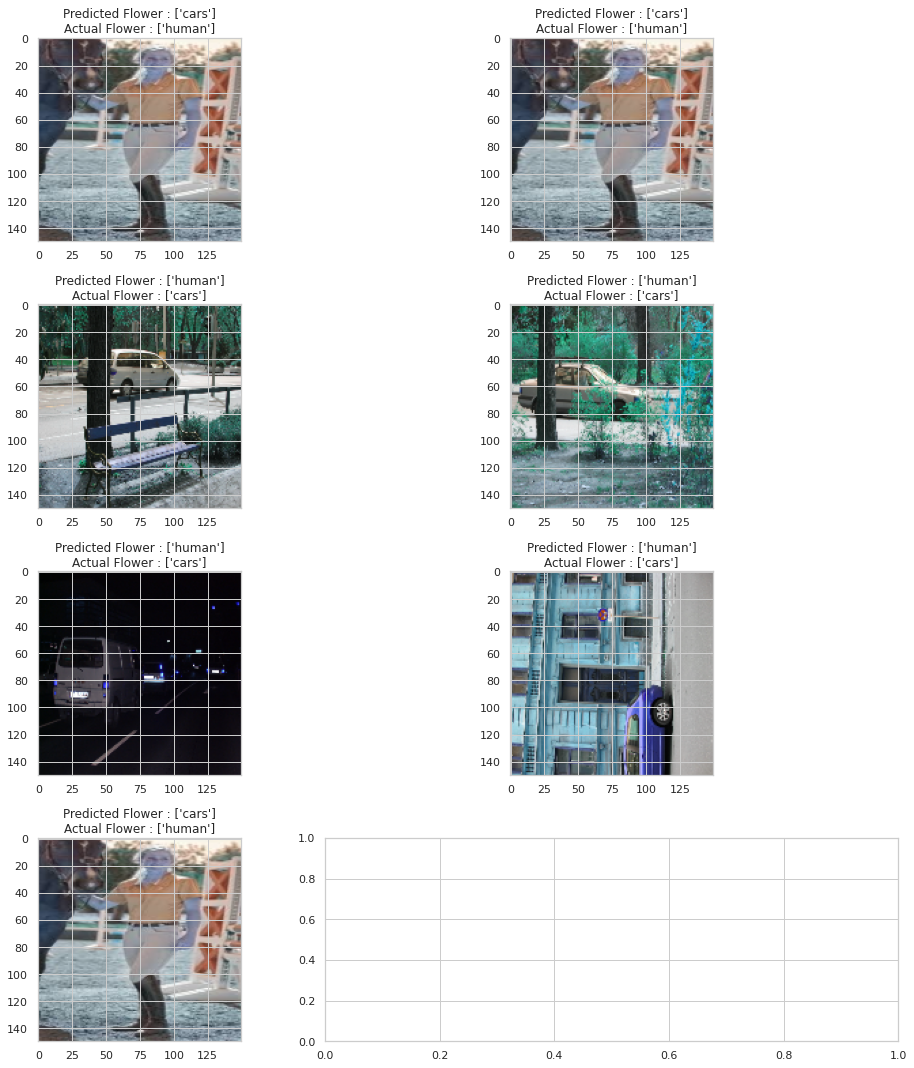

In [53]:
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

count=0
fig,ax=plt.subplots(4,2)
fig.set_size_inches(15,15)
for i in range (4):
    for j in range (2):
        ax[i,j].imshow(x_test[mis_class[count]])
        ax[i,j].set_title("Predicted Flower : "+
        str(le.inverse_transform([pred_digits[mis_class[count]]]))+
        "\n"+"Actual Flower : "+
        str(le.inverse_transform([np.argmax([y_test[mis_class[count]]])])))
        plt.tight_layout()
        count+=1
